# POD-NN method

## The advection-diffusion problem

Let us  considere the following BVP. It is based on the 2D stationary advection-diffusion. It is here parametrized by the diffusivity coefficient $\lambda(\mu)$. The equations read: 

$$\begin{equation}
\begin{cases}
-div(\lambda(\mu)\nabla u)+w\nabla u=f & in~~\Omega\\
~~~~~~\hfill~~~~~~~~~~~~~~~~~~u=g & in~~\varGamma_{in}\\
~~~\hfill~~~~-\lambda(\mu)\nabla u.n=0 & in~~\varGamma_{wall}\\
~~~\hfill~~~~-\lambda(\mu)\nabla u.n=0 & in~~\varGamma_{out}
\end{cases}
\label{eq:Advection-non-affine}
\end{equation}$$

with $\lambda(\mu)=\exp(\mu_{0}(\mu + 1))$. The scalar $\mu_{0}=0.7$ and $\mu\in\textbf{P}=[\mu_{min},{~}\mu_{max}],{~}  \mu_{min}=1,{~} \mu_{max}=10$.

### Modules  import and initializations

In [1]:
### Modules importation
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.datasets import mnist
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kloss
import tensorflow.keras.regularizers as kr
import tensorflow.keras.backend as K
import tensorflow.keras.utils as ku
from tensorflow.keras import callbacks
import scipy as sc
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import sys,os
import random 
#import pandas as pd
import sklearn.utils
# Verbosity
fit_verbosity = 1

2024-12-12 08:50:27.157488: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 08:50:27.216404: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 08:50:28.079157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Normalization and non-affine functions 

In [2]:
# The scaling function for data normalisation
# Scaling function
def scaling(S, S_max, S_min):
    S[ : ] = (S - S_min)/(S_max - S_min)
    
# Inverse scaling function
def inverse_scaling(S, S_max, S_min):
    S[ : ] = (S_max - S_min) * S + S_min
    
# The non-affinity function
def Lambda(mu):
    return np.exp(mu0*(mu+1.))

## The offline phase

### Preparing the data

The RB POD matrix $Brb=[\xi_{1},\dots,\xi_{M}]\in\mathbb{R}^{NN\times N_{rb}}$. The RB matrix is constructed by POD method. It is computed for 100 snapshots of Problem (1). The reduced matrix here is of size $N_{rb}=5$. $$\$$
For the training step of the NN, the snapshots matrix $S=[U_{h}(\mu_{1}),\dots,U_{h}(\mu_{M})]\in\mathbb{R}^{NN\times M}$ has already been computed with $M=10000$.

#### Load the data from numpy files

In [3]:
# Prepare the data
# Load the data from the numpy file
# Snaphots matrix
S =  np.load('Snapshots_non_affine.npy') # of size M*NN
S = S.transpose() # of size NN*M

# The reduced POD basis
Brb = np.load('Brb.npy') # of size NN*Nrb#
Brb = Brb.real
Nrb = len(Brb.transpose())

# The parameter matrix
P = np.load('parameter_non_affine.npy') # of size M x 1
P = P.reshape(len(P),1)

#### Computation of the reduced outputs for the NN and randomly shuffle the data

The reduced outputs are computed by the formula: $$\begin{equation}Urb = Brb^{T}U_{h}(\mu)\in\mathbb{R}^{N_{rb}}\end{equation}$$ with $\mu\in\textbf{P}=[\mu_{min},{~}\mu_{max}]$. $\\$
We denote by $Urb_{POD}=Brb^{T}S$.

In [4]:
# Computation of the reduced solutions: Brb^T*Uh(mu)
Urb_POD = np.dot(Brb.transpose(),S) # of size Nrb*M
#print("Urb_POD size=",Urb_POD.shape)

# Transpose 
Urb_POD = Urb_POD.transpose() # of size M*Nrb
print("Urb_POD size=",Urb_POD.shape)

# Randomy shufl the data set
shuffle = np.arange(len(Urb_POD))
np.random.shuffle(shuffle)
Urb_POD = Urb_POD[shuffle]
P = P[shuffle]
print("Urb_POD before normalization",Urb_POD)
print("P before normalization",P)

Urb_POD size= (10000, 5)
Urb_POD before normalization [[-3.83013819e+01 -1.07669587e+00 -9.61673815e-02  6.78112175e-02
   1.65031134e-02]
 [-3.69161934e+01 -1.54285081e+00  3.01990532e-01 -2.08789233e-02
  -3.53065280e-04]
 [-3.65307743e+01 -1.65873121e+00  4.11256301e-01 -4.97503877e-02
  -7.42885140e-03]
 ...
 [-3.65500215e+01 -1.65305450e+00  4.05816405e-01 -4.82754838e-02
  -7.05482843e-03]
 [-3.62787075e+01 -1.73208650e+00  4.82336901e-01 -6.93619134e-02
  -1.25169073e-02]
 [-3.98853965e+01 -3.53343469e-01 -5.52477554e-01  1.11643943e-01
   1.04988947e-02]]
P before normalization [[ 169.43904563]
 [ 498.27947586]
 [ 865.31734253]
 ...
 [ 835.84471171]
 [1568.50119198]
 [  71.51712945]]


#### Data normalization

The normalization of the data is done as follows: $$\\$$
The input parameters for the NN are such that: $$\begin{equation}\tilde{\mu_{i}} = \frac{\mu_{i}}{\mu_{max}}\end{equation}$$ for $1\leq i\leq M$ $$\$$
The outputs (RB solutions) for the NN are normalized as follows:$$\begin{equation}(\tilde{Urb}_{POD})_{ij} = \frac{(Urb_{POD})_{ij}-\underset{i,j}{\min}(Urb_{POD})_{ij}}{\underset{i,j}{\max}(Urb_{POD})_{ij}-\underset{i,j}{\min}(Urb_{POD})_{ij}}\end{equation}$$ for $1\leq i\leq M$ and $1\leq j\leq N_{rb}$ $$\\$$

In [5]:
# Data normalization
# Normalization of the parameter set
# Obtain the min and the max of P
P_max = np.max(P); P_min = np.min(P)
# Normalize the parameter vector P
P = P/P_max

# Normalization of the reduced matrix
# Obtain the min and the max of the reduced outputs BrbUh
Urb_POD_max = np.max(Urb_POD); Urb_POD_min = np.min(Urb_POD)
scaling(Urb_POD, Urb_POD_max, Urb_POD_min)

print("P after normalization",P)
print("Urb_POD after normalization",Urb_POD)

P after normalization [[0.07672661]
 [0.22563449]
 [0.39183921]
 ...
 [0.37849321]
 [0.71025998]
 [0.0323849 ]]
Urb_POD after normalization [[0.06069094 0.9045865  0.92681539 0.93053284 0.92936967]
 [0.09209361 0.89401861 0.93584176 0.9285222  0.92898753]
 [0.10083118 0.89139157 0.93831885 0.92786768 0.92882712]
 ...
 [0.10039484 0.89152026 0.93819552 0.92790112 0.9288356 ]
 [0.10654562 0.88972858 0.93993027 0.92742308 0.92871177]
 [0.02478082 0.92098513 0.91647069 0.93152654 0.92923355]]


#### Load the already trained NN

In [7]:
# Load the pre-trained NN stored in h5 format
Model = km.load_model('Neural-network.h5', custom_objects={'mse': tf.keras.losses.MeanSquaredError()})

# Summary of the model: layers and number of parameters 
Model.summary()

/home/n7student/miniforge3/envs/env_tensorflow/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-12 08:59:40.250817: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-12 08:59:40.344339: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 17)             │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,104 (16.04 KB)

 Trainable params: 4,102 (16.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## The online phase

### New parameter value

In [8]:
# The onlinbe phase 
# Predict the new solution U_POD_NN
# The constant mu_0
mu0 = 0.7

# New value of the physical parameter mu
print('New value for mu ')
# The parameter input for the NN
mu = np.array([[float(input())]])
print("mu=",mu)

# The non-affine parameter
# TO BE COMPLETED ...
diffus = Lambda(mu)
print("diffus=",diffus)

# Normalization of the non-affine parameter
# TO BE COMPLETED ...
diffus = diffus/P_max
print("diffus after normalization=",diffus)

New value for mu 
mu= [[1.]]
diffus= [[4.05519997]]
diffus after normalization= [[0.0018363]]


### Compute the RB solution for the new parameter value by performing the NN

In [9]:
# Predict the reduced basis solution of the new parameter
# TO BE COMPLETED ...
U_POD_NN = Model.predict(diffus)
print("U_POD_NN=",U_POD_NN)

# Rescaling the predicted reduced basis solution
# TO BE COMPLETED ...
inverse_scaling(U_POD_NN, Urb_POD_max, Urb_POD_min)
print("U_POD_NN after rescaling=",U_POD_NN)

# The change of variable from the RB basis to complete FE one.
# TO BE COMPLETED ...
U_FE_NN = np.dot(Brb,U_POD_NN.transpose())
print("U_FE_NN=",U_FE_NN)

I0000 00:00:1733990388.529098   24050 service.cc:145] XLA service 0x72dfa0009990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733990388.529157   24050 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A500 Laptop GPU, Compute Capability 8.6
2024-12-12 08:59:48.543857: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-12 08:59:48.630533: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
U_POD_NN= [[0.01293175 0.99968356 0.95092124 0.93194085 0.9298653 ]]
U_POD_NN after rescaling= [[-4.0408066e+01  3.1180878e+00  9.6715546e-01  1.2992096e-01
   3.8368225e-02]]
U_FE_NN= [[0.9949374 ]
 [0.9949374 ]
 [0.99569553]
 ...
 [1.0759354 ]
 [1.08006299]
 [1.07737008]]


I0000 00:00:1733990388.738963   24050 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### Save the POD-NN solution in numpy file

In [15]:
U_FE_NN.shape

(1296, 1)

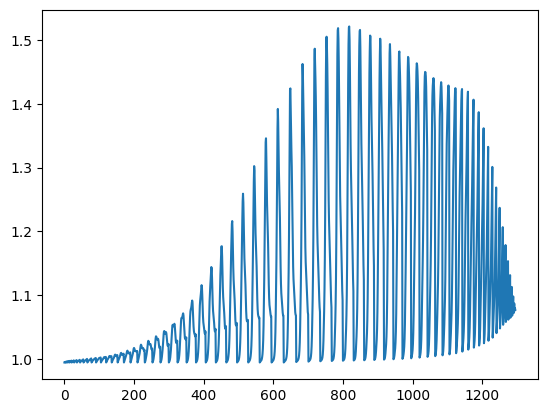

In [17]:
plt.plot(U_FE_NN)

In [18]:
Uh_POD_NN = U_POD_NN
np.save('Uh_POD_NN',Uh_POD_NN)